# 📘 **Step 0. 프로젝트 배경 소개**

## 🛒 **Online Grocery Store Chatbot**

이 프로젝트는 **LangGraph**와 **Gemini LLM**을 기반으로 만든 온라인 마트 챗봇입니다.
사용자는 카테고리를 탐색하거나 제품을 직접 찾지 않고, 챗봇에게 "말로 요청"함으로써 필요한 상품을 찾고 장바구니에 담을 수 있습니다.

### ✅ **주요 기능**

- 제품 카테고리 탐색

- 특정 제품 또는 브랜드 검색

- 가격, 평점, 리뷰 기반 비교

- 장바구니에 담기 / 수정 / 확인

### 💡 **사용 시나리오 예시**

> "show me some milk under $5"

> "compare popcorn brands by rating"

> "what's in my cart?"

이 챗봇은 어떻게 사용자 요청을 이해하고, 어떤 과정을 거쳐 장바구니를 구성할까요?  
이 노트북은 그런 과정을 시각적으로 하나씩 따라가며 설명합니다.

# 📍 **Step 1. LangGraph 구조 시각화 + Tool 소개**

## 📸 **1-1. 구조 이미지 표시**

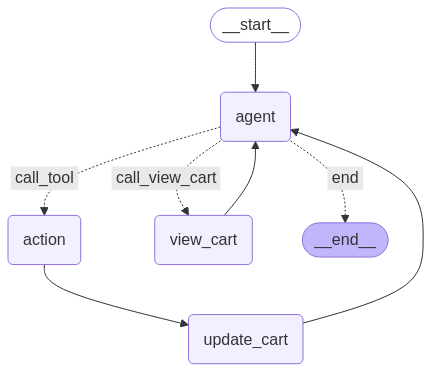

In [1]:
from IPython.display import Image, display

# 그래프 시각화 이미지 파일 경로
display(Image(filename="./assets/graph_image.png", width=480))

## ⚙️ **1-2. LangGraph 구조 설명**

이 챗봇은 LangGraph를 이용하여 다음과 같은 단계로 사용자 요청을 처리합니다:

1. **Agent Node**

   - LLM이 사용자의 요청을 받아 어떤 작업(툴 호출 등)이 필요한지 판단합니다.

2. **Tool Node**

   - 적절한 Tool을 호출하여 실제 상품 검색, 비교, 장바구니 조작 등을 수행합니다.

3. **Update Cart Node**

   - Tool의 결과를 기반으로 장바구니 상태를 갱신합니다.

4. **View Cart Node (별도 처리)**

   - 장바구니를 확인할 때는 별도로 분기하여 확인합니다.

### 🔧 **사용 가능한 주요 Tool 종류**

| 분류 | Tool 이름 (대표 함수 예시) | 설명 | 질문 예시 |
|------|-----------|------|------|
| 🧺 **카테고리 탐색** (유사도 기반) | `search_category_by_type` | 카테고리명 검색 | "do you have vegetables?" |
|                      | `search_category_by_type_all` | 전체 카테고리 리스트 | "what kinds of categories do you have?" |
| 🧂 **상품 탐색** (유사도 기반) | `search_ingredient_by_brand` | 브랜드 또는 제품명으로 검색 | "show me Apple juice" |
|                     | `search_multiple_ingredients` | 여러 제품을 동시에 찾기 | "show me popcorn and milk" |
|                     | `search_ingredient_by_price` | 가격 기준 검색 | "find milk under $3" |
|                     | `search_ingredient_by_rating` | 평점 높은 상품 검색 | "best rated popcorn" |
| 🔍 **상품 비교** | `compare_ingredient_by_price` | 가격으로 브랜드 비교 | "compare milk brands by price" |
|                   | `compare_ingredient_by_rating` | 평점으로 비교 | "which popcorn is best rated?" |
| 🛒 **장바구니 조작** | `add_to_cart`, `remove_from_cart` 등 | 장바구니 관리 | "add 2 oat milks to cart" |
| 🤖 **기타** | `greeting`, `help`, `fallback` | 인사/도움말/잘못된 요청 처리 | "hi", "help", "tell me a joke" |

# 📘 **Step 2. 환경 설정 및 데이터 로드**

## 🧱 **2-1. 환경 설정 (.env 및 config 로드)**

In [2]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

# 설정값 확인
from chatbot.configs import DATA_FILE_PATH, FUZZY_SCORE_THRESHOLD

print("📁 데이터 경로:", DATA_FILE_PATH)
print("🧠 Fuzzy Matching 임계점:", FUZZY_SCORE_THRESHOLD)

📁 데이터 경로: ./data/sample_data.csv
🧠 Fuzzy Matching 임계점: 67


## 🧪 **2-2. 데이터 로드 + 미리보기**

In [3]:
import pandas as pd

try:
    data = pd.read_csv(DATA_FILE_PATH)
    print(f"✅ 데이터 로드 성공! 총 {len(data)}개 항목")
except FileNotFoundError:
    print(f"❌ 데이터 파일을 찾을 수 없습니다: {DATA_FILE_PATH}")
    data = pd.DataFrame()

# 데이터 일부 확인
data.head()

✅ 데이터 로드 성공! 총 120개 항목


,category_type,product_type,product_brand,product_rating,product_review,product_price
0,Vegetables,Carrot,FreshFarm,4.5,150,2.99
1,Vegetables,Carrot,Nature's Best,4.6,120,3.19
2,Vegetables,Carrot,VeggieWorld,4.4,100,2.79
3,Vegetables,Carrot,GreenLeaf,4.7,90,3.09
4,Vegetables,Carrot,FarmSelect,4.3,80,2.89


## **🧾 2-3. 사용 가능한 카테고리 추출**

In [4]:
# ✅ 사용 가능한 카테고리 추출
available_categories = (
    data["category_type"].astype(str).str.strip().str.lower().unique().tolist()
)

print("📦 사용 가능한 카테고리 목록:")
for i, cat in enumerate(available_categories, 1):
    print(f"{i}. {cat}")

📦 사용 가능한 카테고리 목록:
1. vegetables
2. fruits
3. meats
4. dairy
5. bakery
6. beverages
7. snacks
8. frozen foods


# 📘 **Step 3. Warm-Up! 사용자 친화 기능**

## 💡 **3-1. Fuzzy Matching (유사한 단어 매칭)**

In [5]:
from thefuzz import process


def find_closest_category(
    query: str, categories: list[str], threshold: int = 67
) -> dict:
    query = query.strip().lower()
    best_match, score = process.extractOne(query, categories)
    if score >= threshold:
        return {
            "status": "matched",
            "input": query,
            "matched_category": best_match,
            "score": score,
        }
    else:
        return {
            "status": "not_matched",
            "input": query,
            "suggestion": best_match,
            "score": score,
        }


# 예시 입력 테스트
test_inputs = ["veggie", "Veggies", "dairy", "frut", "snakz"]

for query in test_inputs:
    print(find_closest_category(query, available_categories))

{'status': 'matched', 'input': 'veggie', 'matched_category': 'vegetables', 'score': 72}
{'status': 'not_matched', 'input': 'veggies', 'suggestion': 'beverages', 'score': 62}
{'status': 'matched', 'input': 'dairy', 'matched_category': 'dairy', 'score': 100}
{'status': 'matched', 'input': 'frut', 'matched_category': 'fruits', 'score': 80}
{'status': 'matched', 'input': 'snakz', 'matched_category': 'snacks', 'score': 73}


### **✨ Fuzzy Matching**

- 사용자가 정확하게 "vegetables"라고 입력하지 않아도 "veggie", "veggies" 등으로 요청하면 알아서 찾아줍니다.

- 이는 `thefuzz` 라이브러리의 `extractOne()` 기능으로 구현됩니다.

## 💵 **3-2. 가격 필터 예시 (직접 해보는 체험)**

In [6]:
# 💰 특정 제품에 대해 가격 조건으로 필터링
def search_product_under_price(data, product_type: str, max_price: float):
    filtered = data[
        (data["product_type"].str.lower() == product_type.lower())
        & (data["product_price"].astype(float) <= max_price)
    ]
    return filtered[["product_brand", "product_price"]].sort_values(by="product_price")


# 예시: milk 중 가격이 $5 이하인 것들
search_product_under_price(data, "milk", 5.0)

,product_brand,product_price
49,YogurtLand,3.99
48,CheeseCraft,4.09
47,CreamyGold,4.19
45,DairyPure,4.29
46,PureDairy,4.39


### **💵 가격 기준 필터링**

- 사용자가 `"show me milk under $5"` 라고 입력했을 때,<br>시스템은 해당 제품 타입 중 `product_price <= 5` 인 항목을 찾아 정렬해 보여줍니다.

## 🧁 **3-3. 리뷰 수 또는 평점 높은 제품 찾기**

In [7]:
# 🌟 평점 높은 제품 찾기 예시
def find_high_rated_products(data, product_type: str, min_rating: float = 4.0):
    df = data[data["product_type"].str.lower() == product_type.lower()]
    filtered = df[df["product_rating"].astype(float) >= min_rating]
    return filtered[["product_brand", "product_rating"]].sort_values(
        by="product_rating", ascending=False
    )


# 예시: popcorn 중 평점 4.5 이상
find_high_rated_products(data, "popcorn", 4.5)

,product_brand,product_rating
101,SweetBite,4.5


## 🧪 **Warm-Up 요약**

이 파트에서는 챗봇이 어떻게 **사람 중심적인 자연어 요청**을 처리하는지 미리 체험해보았습니다.

- "veggie" → "vegetables"로 자동 매칭

- "milk under $5" → 조건 필터링

- "best popcorn" → 평점 기반 필터링

👉 다음 파트에서는 이러한 기능들이 LangGraph 안에서 어떻게 흘러가는지 시각적으로 살펴봅니다.

# 📘 **Step 4. Warm-Up! LangGraph 구조 분해 설명**

## 🧠 **4-1. 전체 구조 그래프 시각화**

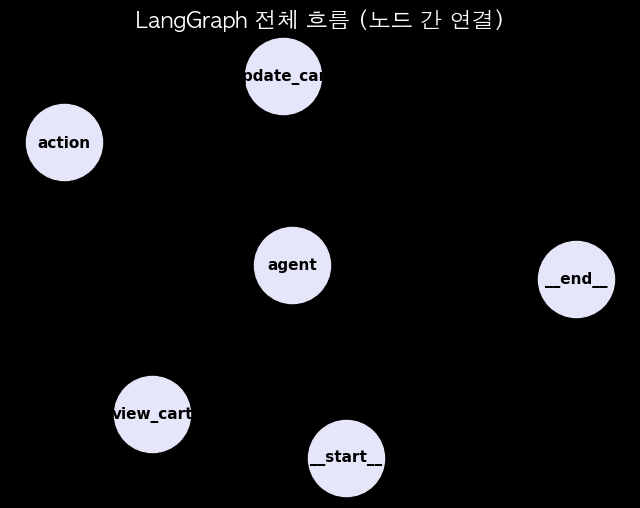

In [8]:
# 🧭 LangGraph 노드/엣지 시각화
import networkx as nx
import matplotlib.pyplot as plt

# 폰트 설정
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.titlesize"] = 16

# 그래프 구성
G = nx.DiGraph()

G.add_edges_from(
    [
        ("__start__", "agent"),
        ("agent", "action"),  # call_tool -> action
        ("action", "update_cart"),
        ("update_cart", "agent"),
        ("agent", "view_cart"),  # call_view_cart -> view_cart
        ("view_cart", "agent"),
        ("agent", "__end__"),  # end
    ]
)

# 시각화
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=2)
nx.draw_networkx(
    G,
    pos,
    node_size=3000,
    node_color="lavender",
    font_size=11,
    font_weight="bold",
)
plt.title("LangGraph 전체 흐름 (노드 간 연결)")
plt.axis("off")
plt.show()

## 🧾 **4-2. 각 Node 역할 정리**

| Node 이름 | 설명 |
|-----------|------|
| `agent` | LLM이 사용자의 메시지를 분석하여 적절한 툴 호출 판단 |
| `action` | 실제 툴을 실행하는 노드 (`ToolNode`) |
| `update_cart` | 툴 실행 결과에 따라 장바구니 상태를 업데이트 |
| `view_cart` | 장바구니를 직접 보여주는 기능 (상태 기반) |
| `__start__` | 그래프의 시작 지점 |
| `__end__` | 대화 종료 지점 |

## 💡 **4-3. 흐름 예시 설명**

예: 사용자가 "add 2 milks of A brand to cart"라고 말했을 때:

1. 사용자가 "add 2 milks of A brand to cart" 요청

2. `agent` → `call_tool` 판단 → `action` 노드에서 `add_to_cart` 실행

3. `update_cart`에서 장바구니에 반영

4. 다시 `agent`로 돌아가 다음 요청을 기다림

예: 사용자가 "what's in my cart?"라고 말했을 때:

1. 사용자가 "what's in my cart?" 요청

2. `agent` → `call_view_cart` 판단

3. `view_cart`에서 장바구니 반환

4. 다시 `agent`로 돌아가 다음 요청을 기다림

## 🔁 **4-4. 상태(State) 구조 이해**

그래프에 전달되는 상태값이 어떤 구조로 되어 있는지 보여줌 (예시)

In [9]:
from chatbot.state import State

# 예시 초기 상태
initial_state = State(
    messages=[],
    cart_items=[],
    category_type=None,
    product_type=None,
    product_brand=None,
    product_rating=None,
    product_review=None,
    product_price=None,
    finished=False,
)

# 구조 확인
initial_state

{'messages': [],
 'cart_items': [],
 'category_type': None,
 'product_type': None,
 'product_brand': None,
 'product_rating': None,
 'product_review': None,
 'product_price': None,
 'finished': False}

## 🧪 **Warm-Up 요약**

LangGraph는 대화의 흐름을 명확하게 시각화하고 추론 흐름을 컨트롤할 수 있게 해줍니다.

- 각 단계는 명확히 분리된 node로 구성됨

- 흐름 제어와 상태 업데이트가 간단명료

- 기능이 복잡해질수록 **LangGraph 구조는 가독성과 유지보수에 강력한 이점**을 가짐

👉 이제 실제 코드를 실행하고, 챗봇과 직접 대화해볼 준비가 되었습니다!

# 📘 **Step 5. 실행 코드 구성**

## ✅ **5-1. 초기 상태 정의**

In [10]:
from chatbot.state import State
from langchain_core.messages import HumanMessage, SystemMessage
from chatbot.configs import SYSTEM_PROMPT

# 대화 초기화
initial_state = State(
    messages=[SystemMessage(content=SYSTEM_PROMPT)],
    category_type=None,
    product_type=None,
    product_brand=None,
    product_rating=None,
    product_review=None,
    product_price=None,
    cart_items=[],
    finished=False,
)

## 🚀 **5-2. 챗봇 실행 함수 정의**

In [11]:
from chatbot.graph import app


def chatbot_turn(state, user_input):
    from langchain_core.messages import HumanMessage

    new_state = state.copy()
    new_state["messages"].append(HumanMessage(content=user_input))

    print(f"\n👤 User: {user_input}")
    print("🤖 Chatbot:")

    for event in app.stream(new_state):
        if "agent" in event:
            agent_response = event["agent"]["messages"][-1].content
            print(agent_response)
        if "update_cart" in event:
            new_state = event["update_cart"]
        if "view_cart" in event:
            view_cart_result = event["view_cart"]["messages"][-1].content
            print(view_cart_result)

    return new_state

[INFO] LLM initialized successfully with model: gemini-2.0-flash
[INFO] Initializing Data Loader
[INFO] CSV data loaded successfully from ./data/sample_data.csv!
[INFO] Available categories: ['vegetables', 'fruits', 'meats', 'dairy', 'bakery', 'beverages', 'snacks', 'frozen foods']
[INFO] Data Loader Initialization Complete
[INFO] Tools List Loaded: ['search_category_by_type', 'search_category_by_type_all', 'search_multiple_ingredients', 'search_ingredient_by_type_all', 'search_ingredient_by_brand', 'search_ingredient_by_rating', 'search_ingredient_by_price', 'search_ingredient_by_review', 'compare_ingredient_by_rating', 'compare_ingredient_by_price', 'compare_ingredient_by_review', 'view_cart', 'add_to_cart', 'remove_from_cart', 'modify_cart', 'clear_cart', 'help', 'greeting', 'fallback']
[INFO] Building Graph
[INFO] LLM successfully bound with tools.
[INFO] Graph compiled successfully!


## ✉️ **5-3. 예시 입력 실행**

In [12]:
current_state = initial_state

# 사용 예시 1
current_state = chatbot_turn(current_state, "Please show me the categories!")


👤 User: Please show me the categories!
🤖 Chatbot:
[INFO] Agent Node Execution
[INFO] Checking for tool call
[INFO] Decision: Tool call required (1 calls, first: search_category_by_type_all) -> Routing to action node


[INFO] Executing tool: search_category_by_type_all
[INFO] Result: Found 8 categories.
[DEBUG] update_cart_node processing ToolMessage: ID=42d25f3d-c79a-466d-b44c-1869cf96afbb, Content Snippet={"status": "success", "categories": ["vegetables", "fruits", "meats", "dairy", "bakery", "beverages"...
[DEBUG] Found corresponding tool call in history: {'name': 'search_category_by_type_all', 'args': {}, 'id': '42d25f3d-c79a-466d-b44c-1869cf96afbb', 'type': 'tool_call'}
[INFO] update_cart_node triggered by tool: search_category_by_type_all
[DEBUG] Successfully parsed ToolMessage content as JSON.
[DEBUG] Cart items after update: 0 types, 0 total items, total price $0.00
[INFO] Agent Node Execution
[INFO] Checking for tool call
[INFO] Decision: No tool call required (End Turn)
OK. H

### ✅ **실행 흐름 요약**

- 사용자가 자연어로 요청을 입력합니다.

- LLM(agent)이 적절한 Tool을 선택하고 실행합니다.

- Tool의 실행 결과는 update_cart 또는 view_cart를 통해 상태에 반영됩니다.

- 다음 대화에서는 이전 상태를 유지한 채로 이어집니다.

👉 아래 셀에서 실제로 챗봇과 대화해보며 흐름을 확인할 수 있습니다.

# 📘 **Step 6. 자유 대화 셀 (인터랙션)**

## ✅ **6-1. 대화 루프용 셀**

In [13]:
# 💬 자유 대화 루프 셀
current_state = initial_state  # 초기 상태에서 시작

while True:
    user_input = input("👤 User (종료하려면 'exit' 입력): ")
    if user_input.lower() in ["exit", "quit", "bye"]:
        print("👋 대화를 종료합니다.")
        break

    current_state = chatbot_turn(current_state, user_input)


👤 User: Hi
🤖 Chatbot:
[INFO] Agent Node Execution
[INFO] Checking for tool call
[INFO] Decision: Tool call required (1 calls, first: search_category_by_type_all) -> Routing to action node


[INFO] Executing tool: search_category_by_type_all
[INFO] Result: Found 8 categories.
[DEBUG] update_cart_node processing ToolMessage: ID=91f5cbac-65cb-41a8-83d1-fbfd345d083e, Content Snippet={"status": "success", "categories": ["vegetables", "fruits", "meats", "dairy", "bakery", "beverages"...
[DEBUG] Found corresponding tool call in history: {'name': 'search_category_by_type_all', 'args': {}, 'id': '91f5cbac-65cb-41a8-83d1-fbfd345d083e', 'type': 'tool_call'}
[INFO] update_cart_node triggered by tool: search_category_by_type_all
[DEBUG] Successfully parsed ToolMessage content as JSON.
[DEBUG] Cart items after update: 0 types, 0 total items, total price $0.00
[INFO] Agent Node Execution
[INFO] Checking for tool call
[INFO] Decision: No tool call required (End Turn)
Here are all of the categories: v

### ✨ **옵션: 단일 입력용 셀 (한 번씩 실험하기 좋아)**

In [ ]:
# # 💡 한 번만 테스트하고 싶을 때
# user_input = "do you have any snacks under $2?"
# current_state = chatbot_turn(current_state, user_input)

## 💬 **자유롭게 대화해보세요!**

실제 챗봇과 대화하며 다음과 같은 요청을 해볼 수 있습니다:

- "show me popcorn brands"

- "compare milk by price"

- "what's in my cart?"

입력을 종료하고 싶다면: `"exit"`, `"quit"` 또는 `"bye"`를 입력하세요.

# 📘 **Step 7. 프로젝트 요약 (장점 / 확장성 / 한계)**

## ✅ **프로젝트 요약**

### 🎯 **주요 장점**

1. **자연어 인터페이스**

- 사용자는 카테고리나 제품명을 정확히 몰라도, 챗봇이 유사도 검색(Fuzzy Matching)을 통해 알아서 찾아줍니다.

2. **툴 기반 처리 구조**  

- LLM은 도구 선택만 판단하고, 실제 행동은 툴이 수행함 → 안정적이고 예측 가능한 흐름

3. **LangGraph 사용**  

- 대화 흐름을 시각적으로 관리할 수 있고, Node/Edge 단위로 흐름을 정제할 수 있음

4. **장바구니 상태 지속 유지**  

- 이전 대화에서의 장바구니 상태가 다음 요청에서도 반영되어 "대화가 이어지는 느낌"을 줍니다

### 🚀 **확장 가능성**

- 🛍 **재고 정보 연동**: 실시간 재고 API 연동 시, 실제 마트와 연결 가능

- 🗣 **음성 I/O 연계**: Whisper + TTS 연결로 "대화하는 마트봇" 제작 가능

- 📱 **UI 프론트엔드**: React, Streamlit 등과 연동하여 챗봇 인터페이스 구성 가능

- 🔄 **추천 시스템 연결**: 이전 구매 이력 기반 추천 시스템 추가 가능

- 😁 **사용자 선호도 반영**: 미리 사용자의 선호도를 반영하여 간결한 대화 가능

### ⚠️ **한계점 및 보완 방향**

- **툴 호출 결과 출력이 텍스트 기반이라 정보 구조화 부족**  
향후 HTML Table, 시각화 추가 필요

- **멀티턴 상태 관리의 한계**  
예: "그거 2개 더 담아줘" 같은 참조 발화 처리 미지원

- **반응 속도**  
LangGraph + LLM Tool 호출 간 처리 시간이 조금 길 수 있음 → 비동기 최적화 고려 가능

---

🎉 감사합니다! 이 노트북을 통해 LangGraph 기반 챗봇이 어떻게 작동하는지 이해하고 직접 체험해보셨길 바랍니다.